In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import math 

data0 = pd.read_csv('convolve_raw_0.dat', sep='\t', header=None, names=['x', 'y', 'value'])
data1 = pd.read_csv('convolve_raw_1.dat', sep='\t', header=None, names=['x', 'y', 'value'])

In [2]:
def meshdata( data ):
    dx = data.x[1] - data.x[0]
    for i in range(len(data)):
        if data.y[i+1] != data.y[i]:
            dy = data.y[i+1] - data.y[i]
            break

    xmin = min(data.x)
    xmax = max(data.x)
    ymin = min(data.y)
    ymax = max(data.y)
    xnew = np.arange(xmin, xmax, dx)
    ynew = np.arange(ymin, ymax, dy)
    X, Y = np.meshgrid(xnew, ynew)
    Znew = np.copy(X)
    Znew[:][:] = np.nan
    for i in range(len(data)):
        xi, yi = data.x[i], data.y[i]
        r2 = ((xi-X)/dx)**2 + ((yi-Y)/dy)**2
        Znew[r2<0.9] = data.value[i] 

    return X, Y, Znew
    
X0, Y0, Z0 = meshdata( data0 )
X1, Y1, Z1 = meshdata( data1 )

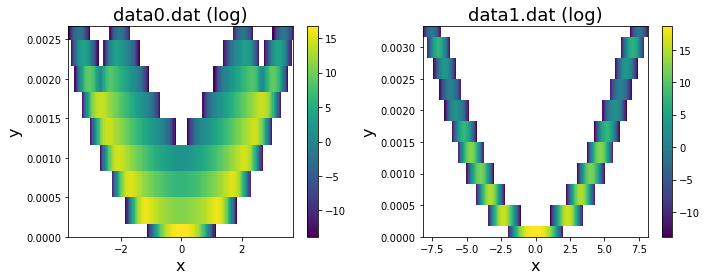

In [3]:
def draw_plot( X, Y, Z, ax, log=False, ptype='pcolormesh' ):
    if log:
        logv = np.vectorize(math.log)
        Z = logv(Z)
    Zmin = Z[~np.isnan(Z)].min()
    Zmax = Z[~np.isnan(Z)].max()
    if ptype == 'pcolormesh':
        im = ax.pcolormesh(X, Y, Z, shading='nearest', 
                            vmin=Zmin, vmax=Zmax )
    else:
        im = ax.contourf(X, Y, Z)
    fig.colorbar(im, ax=ax)

fig, ax = plt.subplots(1,2, figsize=(10,4))
draw_plot( X0, Y0, Z0, ax[0], log=True )
draw_plot( X1, Y1, Z1, ax[1], log=True )
fig.subplots_adjust(wspace=0.25)
fsize_label = 16
fsize_title = 18
for i in range(2):
    title = "data{id}.dat (log)".format(id=str(i))
    ax[i].set_title(title, fontsize=fsize_title)
    ax[i].set_xlabel('x', fontsize=fsize_label)
    ax[i].set_ylabel('y', fontsize=fsize_label)

ax[0].set_ylim([0, Y0.max()])
ax[1].set_ylim([0, Y1.max()])
# ax[0].scatter(data0.x, data0.y, color='r', s=1, alpha=0.3)
# ax[1].scatter(data1.x, data1.y, color='r', s=1, alpha=0.3)
fig.tight_layout()
fig.savefig('convolve_raw.tiff')

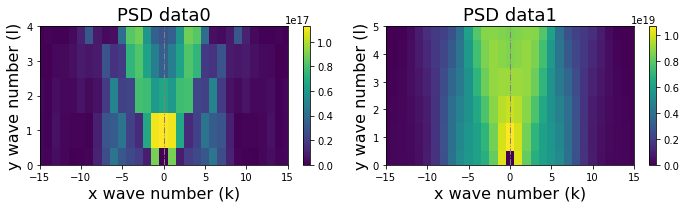

In [4]:
from scipy import fftpack

def Z_to_psd( Z ):
    F1 = fftpack.fft2(Z)
    F2 = fftpack.fftshift( F1 )
    psd = np.abs(F2)**2
    xwave = fftpack.fftfreq(Z.shape[0], 1./Z.shape[0])
    xwave = fftpack.fftshift(xwave)
    ywave = fftpack.fftfreq(Z.shape[1], 1./Z.shape[1])
    ywave = fftpack.fftshift(ywave)
    K, L  = np.meshgrid(ywave, xwave)
    return psd, K, L

# Preprocess prior to FFT
# replace NaN to 0 and then remove the mean
np.nan_to_num(Z0, 0)
np.nan_to_num(Z1, 0)
Z0 = Z0 - Z0.mean(axis=(0,1))
Z1 = Z1 - Z1.mean(axis=(0,1))

psd0, K0, L0 = Z_to_psd( Z0 )
psd1, K1, L1 = Z_to_psd( Z1 )

fig, ax = plt.subplots(1,2, figsize=(10,3))
draw_plot( K0, L0, psd0, ax[0], log=False )
draw_plot( K1, L1, psd1, ax[1], log=False )

for i in range(2):
    ax[i].set_xlim([-15, 15])
    ax[i].set_xlabel('x wave number (k)', fontsize=fsize_label)
    ax[i].set_ylabel('y wave number (l)', fontsize=fsize_label)
    ax[i].set_title('PSD data'+str(i), 
                    fontsize=fsize_title)
    ax[i].axvline(x=0, color='gray', linestyle='-.', linewidth=1)
    
ax[0].set_ylim([0, L0.max()])
ax[1].set_ylim([0, L1.max()])
fig.tight_layout()
fig.savefig('convolve_psd.tiff')